In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import FuncFormatter
import pandas as pd

pd.set_option('display.max_columns', None)

## Load traffic data

In [2]:
nvtraffic = pd.read_csv('../Transportation/tractTraffic_June1/5_output/NV-NM-CO_VMT.csv')
nvtraffic.columns = [column.replace('VMT_','DVMT_') for column in nvtraffic]
nvtraffic.drop(columns ='Unnamed: 0', inplace=True)
nvtraffic = nvtraffic[nvtraffic['STATE'] == 'Nevada']
nvtraffic.drop(columns ='STATE', inplace=True)
nvtraffic.set_index('GEOID',inplace=True)
nvtraffic.drop(columns = nvtraffic.columns[~nvtraffic.columns.str.contains('ex')], inplace=True)
nvtraffic.columns = [column.replace('_ex','') for column in nvtraffic]

In [3]:
nvtraffic

,DVMT_combo,DVMT_sing,DVMT_light
GEOID,,,
32001950100,52272.602565,13852.327865,127609.370466
32001950301,1023.382311,645.239094,17072.789992
32001950302,6584.620946,2519.910253,41597.839235
32001950400,446.516495,159.560644,4696.137535
32001950500,6107.183830,2246.449500,20809.074945
...,...,...,...
32510000702,1670.515079,1234.275395,26232.114396
32510000800,11822.620923,7337.765747,124188.721039
32510000900,2356.959532,2078.458151,47083.507506


In [4]:
traffic_breakdown = pd.DataFrame()
for i in nvtraffic.columns:
    traffic_breakdown[str(i)] = nvtraffic[str(i)]
    traffic_breakdown[str(i)+'_pct'] = nvtraffic[str(i)]/nvtraffic.sum(axis=1)
all_dvmt_inds = traffic_breakdown.columns.str.contains('pct') == False
traffic_breakdown['DVMT_all'] = traffic_breakdown.loc[:,all_dvmt_inds].sum(axis=1)
sucu_inds = traffic_breakdown.columns.str.contains('combo')| traffic_breakdown.columns.str.contains('sing') & ~traffic_breakdown.columns.str.contains('pct')
traffic_breakdown['DVMT_SUCU'] = traffic_breakdown.loc[:,sucu_inds].sum(axis=1)
traffic_breakdown['DVMT_SUCU_pct'] = traffic_breakdown['DVMT_SUCU']/traffic_breakdown['DVMT_all'] 

In [5]:
traffic_breakdown

,DVMT_combo,DVMT_combo_pct,DVMT_sing,DVMT_sing_pct,DVMT_light,DVMT_light_pct,DVMT_all,DVMT_SUCU,DVMT_SUCU_pct
GEOID,,,,,,,,,
32001950100,52272.602565,0.269816,13852.327865,0.071502,127609.370466,0.658682,193734.300896,66125.200246,0.341319
32001950301,1023.382311,0.054605,645.239094,0.034429,17072.789992,0.910966,18741.411397,1668.676010,0.089037
32001950302,6584.620946,0.129868,2519.910253,0.049700,41597.839235,0.820432,50702.370434,9104.661067,0.179571
32001950400,446.516495,0.084213,159.560644,0.030093,4696.137535,0.885694,5302.214675,606.161353,0.114322
32001950500,6107.183830,0.209418,2246.449500,0.077032,20809.074945,0.713551,29162.708274,8353.842747,0.286456
...,...,...,...,...,...,...,...,...,...
32510000702,1670.515079,0.057333,1234.275395,0.042361,26232.114396,0.900305,29136.904869,2904.847807,0.099697
32510000800,11822.620923,0.082474,7337.765747,0.051188,124188.721039,0.866338,143349.107709,19160.469144,0.133663
32510000900,2356.959532,0.045749,2078.458151,0.040344,47083.507506,0.913907,51518.925190,4435.463433,0.086094


In [6]:
cols = nvtraffic.columns
vmt_cols = cols[cols.str.contains('VMT')]
vmt_cols = list(vmt_cols)
print(vmt_cols)

['DVMT_combo', 'DVMT_sing', 'DVMT_light']


## Load emission factors

In [7]:
emissionfactors = pd.read_csv('../Transportation/USDOT_BTS_USAvgMobileSourceEmissionFactors_HCcoNOXpm25_byVehicleType_April2020.csv')

## Convert emission factors for NV vehicle types


In [8]:
diesel_fraction = { 'Heavy-duty vehicles': .894*1.013,
                    'Light-duty trucks':  .045*1.013, 
                    'Light-duty vehicles': .06*1.013}
v_to_t_frac = .5 #light duty vehicle to truck vmt fraction

#split DVMT_light mapping for now
mapping = {
    'DVMT_combo': 'Heavy-duty vehicles',
    'DVMT_sing': 'Heavy-duty vehicles',
    'DVMT_light_trucks': 'Light-duty trucks',
    'DVMT_light_vehicles': 'Light-duty vehicles'
}

In [9]:
reduced_ef = pd.DataFrame(index=pd.unique(emissionfactors.pollutant), columns=mapping.keys())
for col in reduced_ef.columns:
    vehicle_type = mapping[col]
    vehicle_inds = emissionfactors['Vehicle Type'] == vehicle_type
    for pol in reduced_ef.index:
        pol_inds = emissionfactors['pollutant'] == pol
        pol_vehicles = emissionfactors[vehicle_inds & pol_inds]
        frac_vector = np.zeros(pol_vehicles.shape[0])
        frac_vector[pol_vehicles['Fuel Type'] == 'gasoline'] = 1- diesel_fraction[vehicle_type]
        frac_vector[pol_vehicles['Fuel Type'] == 'diesel'] = diesel_fraction[vehicle_type]
        weighted_average = (pol_vehicles['emissions (grams/mile)']*frac_vector).sum()
        reduced_ef.loc[pol, col] = weighted_average

In [10]:
# combine DVMT_light columns
reduced_ef['DVMT_light'] = v_to_t_frac*reduced_ef['DVMT_light_vehicles']+ \
                    (1-v_to_t_frac)*reduced_ef['DVMT_light_trucks']
reduced_ef.drop(columns=['DVMT_light_trucks', 'DVMT_light_vehicles'],inplace=True)

In [11]:
tract_dailyemissions_g = nvtraffic[vmt_cols].dot(reduced_ef.T)
tract_annualemissions_tons = tract_dailyemissions_g * 365 / 1000000

In [12]:
tract_annualemissions_tons['Total PM2.5'] = tract_annualemissions_tons['Exhaust PM2.5'] + tract_annualemissions_tons['Brakewear PM2.5']+tract_annualemissions_tons['Tirewear PM2.5']
tract_annualemissions_tons.drop(columns=['Brakewear PM2.5','Tirewear PM2.5', 'Exhaust PM2.5'],inplace=True)
tract_annualemissions_tons.columns = [column.replace('Total ','') for column in tract_annualemissions_tons]
tract_annualemissions_tons.columns = [column.replace('Exhaust ','') for column in tract_annualemissions_tons]
tract_annualemissions_tons.columns = [column.replace('Co2','CO2') for column in tract_annualemissions_tons]
pollutants = tract_annualemissions_tons.columns

In [13]:
tract_area = pd.read_csv('../Demographic/2018acs5yr_tract.csv')
tract_area.drop(tract_area.columns.difference(['GEOID','tract_area']), 1, inplace=True)
tract_area.set_index('GEOID', inplace=True)

In [14]:
ejscreen = pd.read_csv('../Demographic/Census Tract EJ Index Nevada.csv')
ejscreen.drop(columns = ['STATE_NAME', 'Unnamed: 0'], inplace = True)
ejscreen.set_index('TRACT', inplace = True)

In [15]:
demographics = tract_annualemissions_tons.join(ejscreen).dropna()
demographics = demographics.join(traffic_breakdown).dropna()
demographics = demographics.join(tract_area).dropna()
demographics['pop_density_persqmi'] = demographics['Population']/demographics['tract_area']
demographics['DVMT_all_persqmi'] = demographics['DVMT_all']/demographics['tract_area']
demographics['DVMT_SUCU_persqmi'] = demographics['DVMT_SUCU']/demographics['tract_area']
demographics['DVMT_light_persqmi'] = demographics['DVMT_light']/demographics['tract_area']
demographics['DVMT_combo_persqmi'] = demographics['DVMT_combo']/demographics['tract_area']
demographics['DVMT_sing_persqmi'] = demographics['DVMT_sing']/demographics['tract_area']
demographics['DVMT_all_perpop'] = demographics['DVMT_all']/demographics['Population']

for i in pollutants:
    demographics[str(i) + '_pctile'] = demographics[str(i)].rank(pct=True)
    demographics[str(i) + '_percapita'] = demographics[str(i)]/demographics['Population']
    demographics[str(i) + '_percapita_pctile'] = demographics[str(i) + '_percapita'].rank(pct=True)
    demographics[str(i) + '_per_sqmi'] = demographics[str(i)]/demographics['tract_area']
    demographics[str(i) + '_per_sqmi_pctile'] = demographics[str(i) + '_per_sqmi'].rank(pct=True)
demographics.to_csv('../Demographic/nv_emissions_ejscreen.csv') 

In [16]:
metromicrorural = pd.read_csv('../Demographic/NVNMCOtract_MetroMicroRural.csv')
metromicrorural.drop(metromicrorural.columns.difference(['GEOID','NAME_1','MEMI']), 1, inplace=True)
metromicrorural.set_index('GEOID', inplace=True)
metromicrorural_vegas = metromicrorural[metromicrorural['NAME_1'].str.contains('Vegas') == True]
metromicrorural_vegas = metromicrorural_vegas[metromicrorural_vegas['NAME_1'].str.contains('NV') == True]
metromicrorural_vegas

,NAME_1,MEMI
GEOID,,
32003005804,"Las Vegas-Henderson-Paradise, NV",1
32003002936,"Las Vegas-Henderson-Paradise, NV",1
32003002962,"Las Vegas-Henderson-Paradise, NV",1
32003001804,"Las Vegas-Henderson-Paradise, NV",1
32003003411,"Las Vegas-Henderson-Paradise, NV",1
...,...,...
32003006202,"Las Vegas-Henderson-Paradise, NV",1
32003006203,"Las Vegas-Henderson-Paradise, NV",1
32003002979,"Las Vegas-Henderson-Paradise, NV",1


In [17]:
metro_demographics = metromicrorural[metromicrorural['MEMI'] == 1]
metro_demographics = metro_demographics.join(demographics).dropna()
metro_demographics.to_csv('../Demographic/nv_emissions_ejscreen_metro.csv')

micro_demographics = metromicrorural[metromicrorural['MEMI'] == 2]
micro_demographics = micro_demographics.join(demographics).dropna()
micro_demographics.to_csv('../Demographic/nv_emissions_ejscreen_micro.csv')

rural_demographics = metromicrorural[metromicrorural['MEMI'] == 3]
rural_demographics = rural_demographics.join(demographics).dropna()
rural_demographics.to_csv('../Demographic/nv_emissions_ejscreen_rural.csv')

In [18]:
import cenpy

In [19]:
acs = cenpy.products.ACS(2018)

In [20]:
nv = acs.from_state('NV')
nv.set_index('GEOID', inplace=True)

In [21]:
nv.set_index(nv.index.astype(int),inplace=True)
combo = nv.join(tract_annualemissions_tons).dropna()
combo[pollutants] = combo[pollutants].astype(np.float)

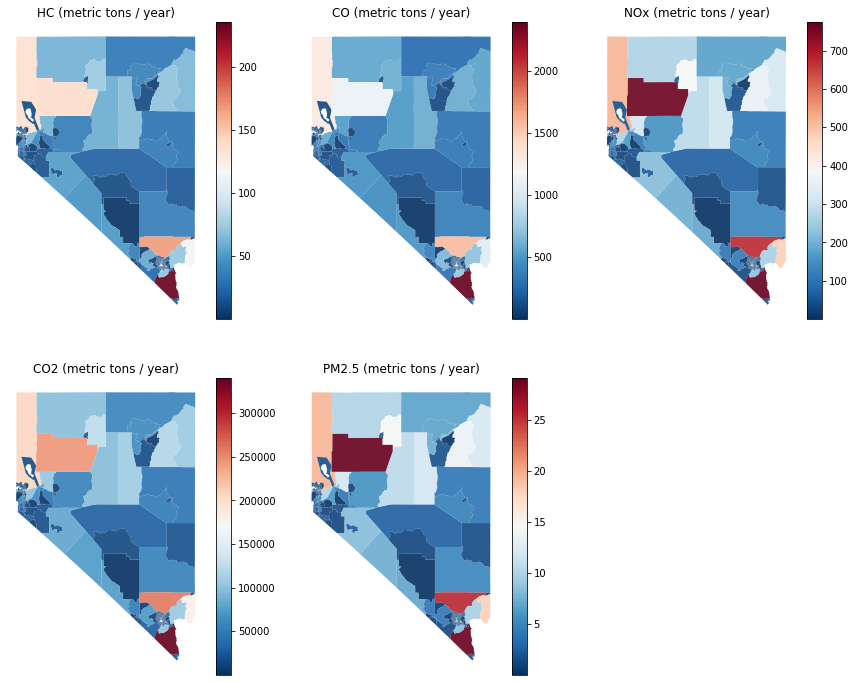

In [22]:
f,ax_array = plt.subplots(2,3, figsize=(15,12))
for i, pol in enumerate(pollutants):
    pol
    ax = np.ravel(ax_array)[i]
    combo.plot(pol, cmap='RdBu_r', ax = ax, alpha=.9, legend=True)
    ax.set_frame_on(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(pol + ' (metric tons / year)')
    
ax_array[-1,-1].set_axis_off()
#plt.savefig('./figures/nevada/NV_pollutantmaps.png',dpi=400)

ax.set_facecolor('k')

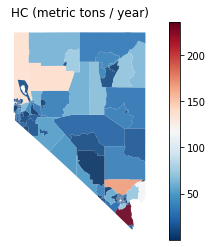

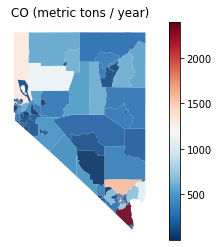

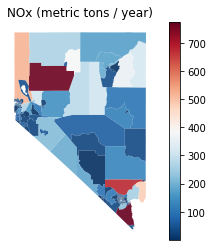

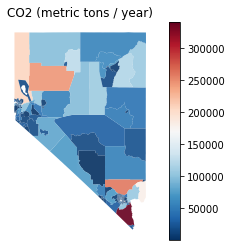

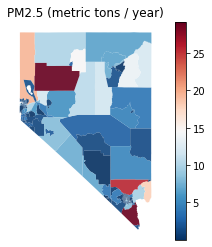

In [23]:
for i, pol in enumerate(pollutants):
#     ax = np.ravel(ax_array)[i]
    combo.plot(pol, cmap='RdBu_r', alpha=.9, legend=True)
    ax = plt.gca()
    ax.set_frame_on(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(pol + ' (metric tons / year)')
    #plt.savefig('./figures/nevada/{} annual_tons_NV_map.png'.format(pol),dpi=400)

ax.set_facecolor('k')

In [24]:
combo_vegas = combo.join(metromicrorural_vegas).dropna()
combo_vegas_persqmi = combo_vegas.join(tract_area).dropna()
combo_vegas_persqmi[pollutants] = combo_vegas_persqmi[pollutants].div(combo_vegas_persqmi['tract_area'].values,axis=0)
combo_vegas_persqmi.drop(columns =['tract_area'])

,geometry,NAME,state,county,tract,HC,CO,NOx,CO2,PM2.5,NAME_1,MEMI
GEOID,,,,,,,,,,,,
32003005843,"POLYGON ((-12839264.460 4322518.190, -12839229...","Census Tract 58.43, Clark County, Nevada",32,003,005843,11.188673,128.356830,22.321996,14166.926787,0.814740,"Las Vegas-Henderson-Paradise, NV",1.0
32003003237,"POLYGON ((-12838961.560 4332213.500, -12838961...","Census Tract 32.37, Clark County, Nevada",32,003,003237,1.807150,22.417627,1.910758,2051.857318,0.065700,"Las Vegas-Henderson-Paradise, NV",1.0
32003005803,"POLYGON ((-12836899.250 4322517.780, -12836860...","Census Tract 58.03, Clark County, Nevada",32,003,005803,1.540460,19.114687,1.623415,1748.307062,0.055796,"Las Vegas-Henderson-Paradise, NV",1.0
32003003240,"POLYGON ((-12836868.970 4331721.260, -12836868...","Census Tract 32.40, Clark County, Nevada",32,003,003240,1.329698,16.499466,1.401304,1509.108310,0.048162,"Las Vegas-Henderson-Paradise, NV",1.0
32003003229,"POLYGON ((-12839156.590 4346771.080, -12839156...","Census Tract 32.29, Clark County, Nevada",32,003,003229,1.391339,16.322641,2.412785,1711.066951,0.087199,"Las Vegas-Henderson-Paradise, NV",1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
32003004911,"POLYGON ((-12809043.000 4319541.150, -12809042...","Census Tract 49.11, Clark County, Nevada",32,003,004911,5.513709,66.785158,7.450298,6486.315048,0.263465,"Las Vegas-Henderson-Paradise, NV",1.0
32003004910,"POLYGON ((-12807017.430 4322579.130, -12807000...","Census Tract 49.10, Clark County, Nevada",32,003,004910,3.811737,47.297658,4.017001,4326.036288,0.138062,"Las Vegas-Henderson-Paradise, NV",1.0
32003005356,"POLYGON ((-12809068.270 4301821.160, -12808986...","Census Tract 53.56, Clark County, Nevada",32,003,005356,0.971845,12.059069,1.024180,1102.971509,0.035200,"Las Vegas-Henderson-Paradise, NV",1.0


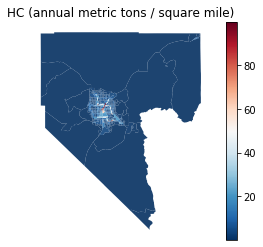

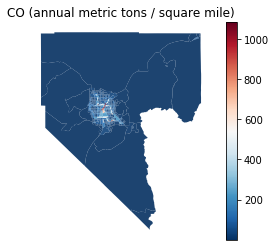

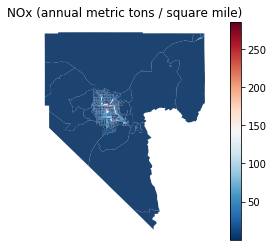

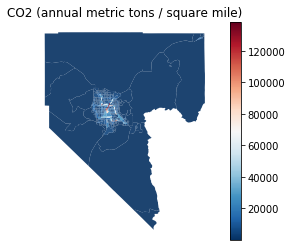

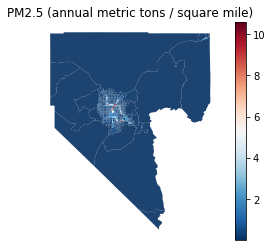

In [25]:
for i, pol in enumerate(pollutants):
#     ax = np.ravel(ax_array)[i]
    combo_vegas_persqmi.plot(pol, cmap='RdBu_r', alpha=.9, legend=True)
    ax = plt.gca()
    ax.set_frame_on(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(pol + ' (annual metric tons / square mile)')
    #plt.savefig('./figures/nevada/{}_vegas_annualtons_persqmi_map.png'.format(pol),dpi=800)

ax.set_facecolor('k')